# PyTorch Model on Real Dataset (v9)

#### Chess Board Object Detection

#### CIS 520, Spring 2019

This notebook is written to run on [Google Colab](https://colab.research.google.com/notebook). Would not recommend running it locally because it downloads multiple GBs of data and runs computationally expensive tasks. (although it should work once you install required packages).

Colab comes with all of the necessary packages preinstalled and gives free GPU access.

## Instructions
* Go to Runtime > Change runtime Type and set it to GPU
* Run all cells
* Some cells will take a few minutes to run:
    - Git imports should take ~5 minutes
    - Preprocessing should take ~15 minutes
    - Actual training time should be less than 20 seconds per epoch
* There is one cell where we import ngrok to open a tensorboard window, sometimes this cell produces a weird error. If this occurs just run it again and it should work.

----


In [1]:
# # Check out available CPU and GPU memory
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

def print_CPU_GPU_info(GPUs):
    ''' Prints out CPU and GPU memory utilization (useful in Google Colab) '''
    process = psutil.Process(os.getpid())
    print(f"\nCPU \tRAM Free: {humanize.naturalsize(psutil.virtual_memory().available)}"
          f"    | Proc size: {humanize.naturalsize(process.memory_info().rss)}")
    if GPUs[0]: 
        for i,gpu in enumerate(GPUs):
            print(f"GPU {i} \tRAM Free: {gpu.memoryFree/1000:.3f} GB  "
                  f"| Used: {gpu.memoryUsed/1000:.3f} GB"
                  f"\t| Utilization: {gpu.memoryUtil*100:3.0f}% | "
                  f"Total Memory: {gpu.memoryTotal/1000:.3f} GB")
    else: print(f"Not on a GPU")


  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [2]:
print_CPU_GPU_info(GPU.getGPUs())


CPU 	RAM Free: 12.9 GB    | Proc size: 119.8 MB
GPU 0 	RAM Free: 15.079 GB  | Used: 0.000 GB	| Utilization:   0% | Total Memory: 15.079 GB


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable scrollable cells

# Pull code and data from GitHub

In [3]:
! git clone https://github.com/samryan18/chess-ray-vision
! mv chess-ray-vision/src/* .
! mv chess-ray-vision/assets/* .
! pip install -e chess-ray-vision

#NOTE this next line will download 2+ GB of data
#Do not run locally unless your comp can take that kinda heat
! rm -rf crvdataset
! git clone https://github.com/mukundv7/crvdataset 
! mkdir train_full
! mv crvdataset/chess-positions/train-full/* train_full/
! rm -rf golden_dataset
! mv crvdataset/golden_dataset golden_dataset

In [0]:
# If you want to preprocess in colab do something like this
# ! mkdir golden_dataset/labeled_preprocessed
# ! preprocess --verbose --glob_path="golden_dataset/good_ass_labels/*.*" --dest_path="golden_dataset/labeled_preprocessed"

In [0]:
# if necessary
import os
def rename_delims(directory: str, 
                  current_delimiter: str=':', 
                  update_delimiter: str="-"):
    '''
    Changes FEN delimiter in filenames.
    
    Some fens are 8-8-8...
    But sometimes for some reason we might want to switch it to 8:8:8...
    This allows us to rename all the files in a directory 
    '''
    for fname in os.listdir(directory):
        src =f'{directory}/{fname}'
        dest = src.replace(current_delimiter,update_delimiter)
        os.rename(src, dest) 

# Setup Stuff

In [4]:
# Pytorch Colab Setup
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
  
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Running on: {device}')

In [8]:
%matplotlib inline

'''
other imports are scattered through the notebook 
near the functions they're used in

sorry.. **shrug**
'''

####################################################
# CODE IMPORTS

from pytorch_general.pytorch_helper import imshow
from pytorch_general.tensorboard_helper import Logger
from utils.data_loading_utils import (onehot_from_fen, fen_from_onehot, 
                                     fen_from_64, fen_from_filename, 
                                     process_image)
from utils.draw_chess_boards import DrawChessPosition

####################################################
# EXTERNAL IMPORTS

import torchvision
import torch 
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import time, datetime
from tqdm import tqdm
from torchsummary import summary

from random import randint

from PIL import Image
from pathlib import Path
from random import shuffle
import os


import glob

import torch.optim as optim
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
# test one hot to/from fen functionality
fen = '4kN1N-bbbbbbbb-QQ3B2-R1n1b3-8-8-ppqKbKbk-8'
class_prob = onehot_from_fen(fen)

print(f"""
Testing one_hot_from_fen function:
Original: \t{fen}
Reconstructed:  {fen_from_onehot(class_prob)}
""")


Testing one_hot_from_fen function:
Original: 	4kN1N-bbbbbbbb-QQ3B2-R1n1b3-8-8-ppqKbKbk-8
Reconstructed:  4kN1N-bbbbbbbb-QQ3B2-R1n1b3-8-8-ppqKbKbk-8



In [10]:
import re
def calculateNaiveAcc(transform=None,
                      root='train_full'):

        pathlist = list(Path(root).glob('**/*.*'))
        n_files = len(pathlist)
        _data = glob.glob(f"{root}/*.*")
        dataset_size = len(os.listdir(root))
        labels = []

        for idx in range(dataset_size):
            img = _data[:dataset_size][idx]
            img_label = re.sub(r'[\_][0-9]+', '',img) # remove underscores for dups
            try:
                label = onehot_from_fen(fen_from_filename(img_label))
                labels.append(label)
            except:
                print(img)
                raise
        flat = np.array(labels[:][:][:]).astype(int).flatten()
        
        counts = np.bincount(flat)
        most_common = np.argmax(counts)
        naive_acc = np.mean( flat == most_common )
        print (f'Total Number of labeled Spaces: {np.shape(flat)[0]}\n'
               f'Most Common Element: {most_common} '
               f'\nAccuracy of Guessing that Every Time: {naive_acc}')
        return naive_acc

naive_acc = calculateNaiveAcc(root='golden_dataset/labeled_preprocessed') 




Total Number of labeled Spaces: 416000
Most Common Element: 0 
Accuracy of Guessing that Every Time: 0.9230769230769231


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pickle

def save_image_pickles_to_drive(dataset: Dataset, 
                                data_save_name = "dataset2.p"):
    ''' Saves preprocessed data pickle to drive '''
    path = F"/content/gdrive/My Drive/{data_save_name}" 
    pickle.dump( (dataset), open( path, "wb" ) )

def load_image_pickles_from_drive(data_save_name = "dataset2.p") -> Dataset:
    ''' Loads preprocessed data pickle from drive '''
    model_save_name = 'classifier.pt'
    path = F"/content/gdrive/My Drive/{data_save_name}"
    dataset = pickle.load( open( path, "rb" ) )
    return dataset


def save_model_to_drive(model: nn.Module, 
                        model_save_name: str = 'classifier.pt'):
    ''' Saves a pytorch model to drive '''
    path = F"/content/gdrive/My Drive/{model_save_name}" 
    torch.save(model.state_dict(), path)

def load_model_from_drive(model: nn.Module, 
                          model_save_name: str = 'classifier.pt') -> nn.Module:
    ''' Loads a pytorch model from drive '''
    model_save_name = 'classifier.pt'
    path = F"/content/gdrive/My Drive/{model_save_name}"
    model.load_state_dict(torch.load(path))
    return model

# Dataloader

In [11]:
# This cell will take ~15 mintues to run

from skimage.util.shape import view_as_blocks
from skimage import transform as sktransform
from skimage import io

def process_image(img, downsample_size = 200):
    square_size = int(downsample_size/8)

    img = sktransform.resize(io.imread(img), 
                                  (downsample_size, downsample_size), 
                                  mode='constant',
                                  anti_aliasing=True)
    tiles = view_as_blocks(img[:,:,0:3], 
                           block_shape=(square_size, square_size, 3))
    return tiles.reshape(64, square_size, square_size, 3), img



import os
import re
class CustomChessDataset(Dataset):
    """Chess dataset"""

    def __init__(self, 
                 transform=None,
                 root='train_full',
                 dataset_size = None,
                 downsample_size = 200):

        self.downsample_size = downsample_size
            
        self.root = root
        self.pathlist = list(Path(self.root).glob('**/*.*'))
        self.n_files = len(self.pathlist)
        
        self._data = glob.glob(f"{root}/*.*")
        
        if dataset_size == None:
            dataset_size = len(os.listdir(root))

        self.dataset_size = dataset_size
        shuffle(self._data)

        self._data = self._data[:self.dataset_size]

        # to speed up training loop preprocess all data early and cache results
        # 130x speedup!
        with tqdm(total=self.dataset_size, 
                  desc=f'Preprocessing Images: ', 
                  unit=' images') as pbar:
            for idx in tqdm(range(self.dataset_size)):
                img = self._data[idx]
                img_label = re.sub(r'[\_][0-9]+', '',img) # remove underscores for dups
                try:
                    label = onehot_from_fen(fen_from_filename(img_label))
                except:
                    print(img)
                    raise

                img_as_img, original_img = process_image(img, 
                                                         downsample_size = self.downsample_size)
                self._data[idx] = (img_as_img, label, original_img)
                pbar.update(1)

    def __len__(self):
        return self.dataset_size
    
    def __getitem__(self, idx):
        img_as_img, label, original_img = self._data[idx]
        return ((torch.from_numpy(img_as_img).float()), 
                label,
                original_img)
    
# BATCH_SIZE needs to be small ish bc bigger models will scale 
# memory usage exponentially
BATCH_SIZE=10
downsample_size=200
transform = transforms.Compose([transforms.Resize(downsample_size)])

# train_full/

# comment this out once dataset is saved to drive
dataset = CustomChessDataset(root='golden_dataset/labeled_preprocessed', 
                                   downsample_size=downsample_size) 
save_image_pickles_to_drive(dataset)

# uncomment this if you already have a preprocessed dataset saved in drive
# loads from pickle file (if there is one saved in google drive)
# dataset = load_image_pickles_from_drive()

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/util/shape.py:94: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
100%|██████████| 500/500 [15:04<00:00,  1.73s/it]



In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
def make_samplers(dataset, 
                  validation_split=0.04,
                  test_split=.1,
                  shuffle_dataset = True,
                  random_seed= 20):
    ''' Makes samplers to split train and test data '''
    
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_ind = int(np.floor(validation_split * dataset_size))
    test_ind = val_ind+int(np.floor(test_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    val_indices = indices[:val_ind]
    test_indicies = indices[val_ind:test_ind]
    train_indices = indices[test_ind:]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indicies)

    return train_sampler, val_sampler, test_sampler

In [15]:
train_sampler, val_sampler, test_sampler = make_samplers(dataset,
                                          validation_split=0.06,
                                          test_split=.1,
                                          shuffle_dataset = True)

train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=BATCH_SIZE,
                                           sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=BATCH_SIZE,
                                           sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=BATCH_SIZE,
                                          sampler=test_sampler)  

print(f'Train loader contains {len(train_loader)} batches of size {BATCH_SIZE}')
print(f'Val loader contains {len(val_loader)} batches of size {BATCH_SIZE}')
print(f'Test loader contains {len(test_loader)} batches of size {BATCH_SIZE}')

Train loader contains 42 batches of size 10
Val loader contains 3 batches of size 10
Test loader contains 5 batches of size 10


# Training Function

In [0]:
from typing import Tuple

def train_model(model: nn.Module, 
                log_dir: str,
                train_loader: torch.utils.data.DataLoader,
                criterion: torch.nn.modules.Module,
                optimizer: torch.optim.Optimizer,
                num_epochs: int=1,
                log_freq: int=5,
                print_guess=False,
                print_guess_freq=50,
                test_model_after_each_epoch=False,
                val_loader: torch.utils.data.DataLoader=None,
                test_loader: torch.utils.data.DataLoader=None,
                suppress_output: bool=True,
                disable_tqdm: bool=False,
            ) -> Tuple[nn.Module, str]:
    ''' A messy training loop with lots of extraneous logging functionality '''
    
    # Create Logging Directory for Tensorboard
    now = time.mktime(datetime.datetime.now().timetuple()) - 1550000000
    log_dir = f'{log_dir} ({now})/'
    logger = Logger(log_dir)
    print(f'Training model. Logging to: "{log_dir}"\n')

    model = model.to(device) # Send model to GPU if possible
    model.train() # Set model to training mode
    
    # for drawing predictions to images
    renderer = DrawChessPosition(delimiter='-')
    
    def validate_model(model, overall_step, loader=None, val=False):
        accu = test_model(model, loader, criterion, 
                                       print_guess=False, 
                                       disable_tqdm=disable_tqdm)
        if not val: return accu
        else:
            info = { 'validation_accuracy': accu }
            for key, value in info.items():
                logger.scalar_summary(key, value, overall_step)
        return accu

    total_step = len(train_loader)
    validate_model(model, overall_step=0, loader=val_loader, val=True)
    for epoch in range(num_epochs):
        if print_guess: print(f'Epoch {epoch+1}')
        running_loss = 0
        
        
        # Tqdm will create a progress bar
        with tqdm(total=len(train_loader), 
                  desc=f'Epoch {epoch+1}', 
                  unit=' minibatches',
                  disable=(print_guess or disable_tqdm)) as pbar:
            
            # Iterate through minibatches
            for step, (images, labels, original_imgs) in enumerate(train_loader):
                images, labels = images.to(device), labels.long().to(device)

                output = model(images).to(device)
                _,class_labels = torch.max(labels,2) 
                _, argmax = torch.max(output, 2)

                accuracy = float((class_labels == 
                                  argmax.squeeze()).float().mean().cpu())

                loss = criterion(output.reshape(10*64,13).float(),
                                 class_labels.reshape(10*64))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += float(loss.item())

                pbar.set_postfix(training_accuracy=accuracy, loss=loss.item(), refresh=True)
                pbar.update(1)

                if step % log_freq == 0:
                    overall_step = epoch*total_step + step
                    
                    info = { 'loss': loss.item(), 'accuracy': accuracy }

                    for key, value in info.items():
                        logger.scalar_summary(key, value, overall_step)
                    

                    info = { f'{fen_from_64(argmax.cpu()[0])}': 
                                    [original_imgs[0].cpu()]}

                    for tag, images in info.items():
                        logger.image_summary(tag, images, overall_step)

                    for key, value in model.named_parameters():
                        key = key.replace('.', '/')
                        logger.histo_summary(key, 
                                             value.data.cpu().numpy(), 
                                             overall_step)
                        try:
                            logger.histo_summary(key+'/grad', 
                                                 value.grad.data.cpu().numpy(),
                                                 overall_step)
                        except (AttributeError):
                            # During transfer learning some of the variables 
                            # don't have grads
                            pass

                if print_guess and step % print_guess_freq == 0:
                    overall_step = epoch*total_step + step
                    print(f"\n{60*'-'}\nBatch Number: {overall_step}")
                    print(f"Example training point:")
                    print(f"Actual: {fen_from_64(class_labels.cpu()[0])}")
                    print(f"Guess: {fen_from_64(argmax.cpu()[0])}")
                    print(f"Example Accuracy: {float((class_labels[0] == argmax[0]).float().mean().cpu())}")

                    board_actual = renderer.draw(fen_from_64(class_labels.cpu()[0]))
                    board_guess = renderer.draw(fen_from_64(argmax.cpu()[0]))
                    renderer.show_side_by_side(board1= original_imgs[0],
                                               board2=board_guess, 
                                               board1_title='Actual (Preprocessed)',
                                               board2_title='Prediction (Re'
                                                            'ndered to image)')
        
        if not suppress_output:   
            print(f"{epoch}: Training loss: {running_loss/len(train_loader)}")
            print(f"{epoch}: Training accuracy: {accuracy}")
        
        if test_model_after_each_epoch:
            validate_model(model, overall_step=overall_step, loader=val_loader, val=True)
        

    final_val_acc = validate_model(model, overall_step=overall_step, loader=val_loader, val=True)
    final_train_acc = validate_model(model, overall_step=overall_step, loader=train_loader)
    final_test_acc = validate_model(model, overall_step=overall_step, loader=test_loader)
    return (model, log_dir, final_train_acc, final_val_acc, final_test_acc)

def test_model(model: nn.Module, 
                test_loader: torch.utils.data.DataLoader,
                criterion: torch.nn.modules.Module,
                print_guess: bool=False,
                print_guess_freq: int=50,
                suppress_output: bool=True,
                disable_tqdm: bool=False,) -> float:
    
    model = model.to(device)
    accuracies = []
    losses = []
    total_step = len(test_loader)
        
    # for drawing predictions to images
    renderer = DrawChessPosition(delimiter='-')
    with torch.no_grad():
        # Tqdm will create a progress bar
        with tqdm(total=len(test_loader), 
                desc=f'Test Batches', 
                unit=' minibatches',
                disable=(print_guess or disable_tqdm)) as pbar:

            # Iterate through minibatches
            for step, (images, labels, original_imgs) in enumerate(test_loader):
                images, labels = images.to(device), labels.long().to(device)

                output = model(images).to(device)
                _,class_labels = torch.max(labels,2) 
                _, argmax = torch.max(output, 2)

                accuracy = float((class_labels == 
                                argmax.squeeze()).float().mean().cpu())

                loss = criterion(output.reshape(10*64,13).float(),
                                class_labels.reshape(10*64))
                losses.append(float(loss.item()))
                accuracies.append(accuracy)

                pbar.set_postfix(test_acc=accuracy, test_loss=loss.item(), refresh=True)
                pbar.update(1)

                if print_guess and step % print_guess_freq == 0:

                    overall_step = total_step + step
                    print(f"\n{60*'-'}\nTest Batch Number: {overall_step}")
                    print(f"Example testing point:")
                    print(f"Actual: {fen_from_64(class_labels.cpu()[0])}")
                    print(f"Guess: {fen_from_64(argmax.cpu()[0])}")
                    print(f"Example Accuracy: {float((class_labels[0] == argmax[0]).float().mean().cpu())}")

                    board_actual = renderer.draw(fen_from_64(class_labels.cpu()[0]))
                    board_guess = renderer.draw(fen_from_64(argmax.cpu()[0]))
                    renderer.show_side_by_side(board1= original_imgs[0],
                                            board2=board_guess, 
                                            board1_title='Actual',
                                            board2_title='Prediction (Re'
                                                            'ndered to image)')

    if not suppress_output:                   
        print(f'\nAvg. Accuracy of the network on test images: {np.average(accuracies)}')
        print(f'Avg. Loss of the network on test images: {np.average(losses)}')

    return np.average(accuracies)

def view_classify(model: nn.Module, 
                data_loader: torch.utils.data.DataLoader,
                num_view: int=2):
    ''' Prints some board images from our dataset with classifications  '''
    
    model = model.to(device)
    total_step = len(data_loader)
        
    # for drawing predictions to images
    renderer = DrawChessPosition(delimiter='-')
    num_seen = 0
    with torch.no_grad():

        # Iterate through minibatches
        for step, (images, labels, original_imgs) in enumerate(data_loader):
            images, labels = images.to(device), labels.long().to(device)

            output = model(images).to(device)
            _,class_labels = torch.max(labels,2) 
            _, argmax = torch.max(output, 2)


            for i in range(len(class_labels.cpu())):
                print(f"Example image:")
                print(f"Actual: {fen_from_64(class_labels.cpu()[i])}")
                print(f"Guess: {fen_from_64(argmax.cpu()[i])}")
                print(f"Example Accuracy: {float((class_labels[i] == argmax[i]).float().mean().cpu())}")

                board_actual = renderer.draw(fen_from_64(class_labels.cpu()[i]))
                board_guess = renderer.draw(fen_from_64(argmax.cpu()[i]))
                renderer.show_side_by_side(board1= original_imgs[i],
                                        board2=board_guess, 
                                        board1_title='Example Actual '
                                                     'Validation Image',
                                        board2_title='Prediction (Re'
                                                     'ndered to image)')
                num_seen+=1
                if num_seen >= num_view:
                    break
            if num_seen >= num_view:
                    break

# Utility Code for viewing tensorboard plots with matplotlib

In [0]:
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})


def smooth(scalars, weight: 0.5):
    # tensorboard style smoothing
    last = scalars[0]
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

def load_tf_log(path):
    tf_size_guidance = { 
        'compressedHistograms': 10, 'histograms': 1, 'images': 0, 
        'scalars': 40000000, }

    event_acc = EventAccumulator(path, tf_size_guidance)
    event_acc.Reload()
    
#     print(event_acc.Tags()['scalars']) # Show all tags in the log file
#     scalars = event_acc.Tags()['scalars']
#     for scalar in scalars:
#         data = event_acc.Scalars(scalar)
    accuracies = event_acc.Scalars('accuracy')
    losses = event_acc.Scalars('loss')
    validation_accuracies = event_acc.Scalars('validation_accuracy')
    return accuracies, losses, validation_accuracies

def plot_tensorflow_log(path, title='', figsize=(8,6)):
    # Loading too much data is slow... (but fuck it)
    accuracies, losses, validation_accuracies = load_tf_log(path)

    steps = len(accuracies)
    x = np.arange(steps)
    
    y = np.zeros([steps, 2])
#     print(accuracies[1][1])

    for i in range(steps):
        
        x[i] = accuracies[i][1]
        y[i, 0] = accuracies[i][2] # value
        y[i, 1] = losses[i][2]
    
    
    val_steps = len(validation_accuracies)
    x_val = np.arange(val_steps)
    y_val = np.zeros(val_steps)
    for i in range(val_steps):
        x_val[i] = validation_accuracies[i][1]
        y_val[i] = validation_accuracies[i][2] # value
        

    
    f, axarr = plt.subplots(1,2, figsize=(2*figsize[0],figsize[1]))
        
    axarr[0].plot(x, y[:,0], label='training accuracy')
    axarr[0].plot(x_val, y_val, label='validation accuracy')
    axarr[0].set_title(f'Accuracy Over Training {title}')
    axarr[0].set_ylabel("Accuracy")
    axarr[1].plot(x, y[:,1], label='loss')
    axarr[1].set_title('Loss Over Training')
    axarr[1].set_ylabel("Loss")
    for ax in axarr:
        ax.set_xlabel("Mini-batches (10 images per batch)")
        ax.grid()
        ax.legend(frameon=True)
        
    plt.show()
    
def plot_tensorflow_logs(paths, 
                         figsize=(12,14), 
                         include_val: bool=True, 
                         inverse_log: bool=True,
                         ylim=None,
                         smoothing_weight=0.0,
                         tb_data=None,
                        include_legend=True):
    if not tb_data:
        print('Loading tensorboard data.')
        tb_data = {}
        # Loading too much data is slow... (but fuck it)
        for path in paths:
            accuracies, losses, validation_accuracies = load_tf_log(path)

            steps = len(accuracies)
            x = np.arange(steps)

            y = np.zeros([steps, 2])
            for i in range(steps):
                x[i] = accuracies[i][1]
                y[i, 0] = accuracies[i][2] # value
                y[i, 1] = losses[i][2]


            val_steps = len(validation_accuracies)
            x_val = np.arange(val_steps)
            y_val = np.zeros(val_steps)
            for i in range(val_steps):
                x_val[i] = validation_accuracies[i][1]
                y_val[i] = validation_accuracies[i][2] # value

            tb_data[path] = {'x': x,'y': y,'x_val': x_val,'y_val': y_val}

    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')
    f, axarr = plt.subplots(2,1, figsize=(figsize[0],figsize[1]))
    colors = [mcolors.to_rgba('black')[:3], 'b', 'g', 'r', 'c', 'm', 'y', 'k', 
              mcolors.to_rgba('forestgreen')[:3],
              mcolors.to_rgba('chocolate')[:3],
              mcolors.to_rgba('yellow')[:3]]
    for i, (k,model_data) in enumerate(tb_data.items()):
        x,y = model_data['x'],model_data['y']
        if i == 0:
            y_naive = naive_acc*np.ones(len(x))
            if inverse_log: y_naive = 1-y_naive
            axarr[0].plot(x,y_naive, 
                      color=mcolors.to_rgba('darkorange')[:3],
                      label=f'Naive Accuracy')


        model_name = k.split('logs/')[1].split('_')[0]

        y[:,0] = smooth(y[:,0], weight = smoothing_weight)

        if inverse_log: y[:,0] = 1-y[:,0]
        if include_val:
            axarr[0].plot(x, y[:,0], 
                          color=colors[i%len(colors)],
                          label=f'{model_name} training accuracy')
        else:
            axarr[0].plot(x, y[:,0], 
                          color=colors[i%len(colors)],
                          label=f'{model_name} training accuracy')
        axarr[1].plot(x, y[:,1], label=f'{model_name} loss')


        if include_val:
            x_val,y_val = model_data['x_val'],model_data['y_val']
            if inverse_log: y_val = 1-y_val
            axarr[0].plot(x_val, y_val, 
                          color=colors[i%len(colors)], 
                          linestyle= ':',
                          label=f'{model_name} validation accuracy')

    for ax in axarr:
        ax.set_xlabel("Mini-batches (10 images per batch)")
        ax.grid()
        if include_legend:
            ax.legend(frameon=True)
    axarr[0].set_title(f'Learning Curves: Training and Validation Accuracy of Final Model')        
    axarr[0].set_ylabel('Accuracy')

    if inverse_log:
        axarr[0].set_title(f'Accuracy Over Training (inverse log scale)')
        axarr[0].set_yscale('log')
        axarr[0].invert_yaxis()
        axarr[0].set_yticklabels(1-axarr[0].get_yticks())
    if ylim:
        axarr[0].set_ylim(ylim)

    axarr[1].set_title('Loss Over Training')
    axarr[1].set_ylabel('Loss')

    plt.show()
    return tb_data

# Models

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1) 
    
class LogisticRegression(nn.Module):
    def __init__(self, batch_size):
        super(LogisticRegression, self).__init__()
        self.name = 'LogisticRegression (L2 regularization)'
        self.batch_size = batch_size
        self.flatten = Flatten()
        self.fc1 = nn.Linear(64*25*25*3, 64*13)
    def forward(self, x):
        out = self.flatten(x)
        out = self.fc1(out)
        out = out.reshape(self.batch_size,64,13)
        return out

class FullyConnected(nn.Module):
    def __init__(self, batch_size):
        super(FullyConnected, self).__init__()
        self.name = 'FullyConnected'
        self.batch_size = batch_size
        self.flatten = Flatten()
        self.fc1 = nn.Linear(64*25*25*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64*13)

    def forward(self, x):
        out = self.flatten(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = out.reshape(self.batch_size,64,13)
        return out
    
class CNN_NoDropout(torch.nn.Module):
    def __init__(self, batch_size):
        super(CNN_NoDropout, self).__init__()
        self.name = 'CNN (Leaky ReLU)'
        self.batch_size=batch_size
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.1))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU())
        self.flatten = Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(64*19*19, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(256, 13))

    def forward(self, x):
        x = x.reshape(self.batch_size*64,3,25,25)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.reshape(self.batch_size,64,13)
        return(x)

class CNN_BatchNorm(torch.nn.Module):
    def __init__(self, batch_size):
        super(CNN_BatchNorm, self).__init__()
        self.name = 'CNN (BatchNorm, Leaky ReLU)'
        self.batch_size=batch_size
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.flatten = Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(64*19*19, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(256, 13))

    def forward(self, x):
        x = x.reshape(self.batch_size*64,3,25,25)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.reshape(self.batch_size,64,13)
        return(x)
    
class CNN_Dropout(torch.nn.Module):
    def __init__(self, batch_size):
        super(CNN_Dropout, self).__init__()
        self.name = 'CNN (Dropout, Leaky ReLU)'
        self.batch_size=batch_size
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(p = 0.05))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Dropout(p = 0.05))
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU())
        self.flatten = Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(64*19*19, 512),
            nn.ReLU(),
            nn.Dropout(p = 0.05))
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(256, 13))

    def forward(self, x):
        x = x.reshape(self.batch_size*64,3,25,25)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.reshape(self.batch_size,64,13)
        return(x)
    

class CNN_Dropout_BatchNorm(torch.nn.Module):
    def __init__(self, batch_size):
        super(CNN_Dropout_BatchNorm, self).__init__()
        self.name = 'CNN (BatchNorm, Dropout, Leaky ReLU)'
        self.batch_size=batch_size
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(p = 0.05))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(p = 0.05))
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.flatten = Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(64*19*19, 512),
            nn.ReLU(),
            nn.Dropout(p = 0.05))
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(256, 13))

    def forward(self, x):
        x = x.reshape(self.batch_size*64,3,25,25)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.reshape(self.batch_size,64,13)
        return(x)
    
class CNN_BatchNormLessFiltersLastLayer(torch.nn.Module):
    def __init__(self, batch_size):
        super(CNN_BatchNormLessFiltersLastLayer, self).__init__()
        self.name = 'CNN (BatchNorm, Less Filters Last Layer, Leaky ReLU)'
        self.batch_size=batch_size
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.flatten = Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(16*19*19, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(256, 13))

    def forward(self, x):
        x = x.reshape(self.batch_size*64,3,25,25)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.reshape(self.batch_size,64,13)
        return(x)

class CNN_BatchNormLessFilters(torch.nn.Module):
    def __init__(self, batch_size):
        super(CNN_BatchNormLessFilters, self).__init__()
        self.name = 'CNN (BatchNorm, Less Filters, Leaky ReLU)'
        self.batch_size=batch_size
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.1))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.flatten = Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(16*19*19, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(256, 13))

    def forward(self, x):
        x = x.reshape(self.batch_size*64,3,25,25)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.reshape(self.batch_size,64,13)
        return(x)
    
class CNN_LessFilters(torch.nn.Module):
    def __init__(self, batch_size):
        super(CNN_LessFilters, self).__init__()
        self.name = 'CNN (Less Filters, Leaky ReLU)'
        self.batch_size=batch_size
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.1))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU())
        self.flatten = Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(16*19*19, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(256, 13))

    def forward(self, x):
        x = x.reshape(self.batch_size*64,3,25,25)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.reshape(self.batch_size,64,13)
        return(x)

In [25]:
# Sometimes this cell gives a weird error
# Just rerun it until it works

! rm -rf logs

LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi


get_ipython().system_raw('./ngrok http 6006 &')
# ! echo "get_ipython().system_raw('./ngrok http 6006 &')" > background_ngrok.py

# run in background so that connection does not die when we kill cells
# import os
# os.system("python background_ngrok.py &")


! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Ngrok already installed
Tensorboard Link: https://1c373b50.ngrok.io


Training: CNN (Less Filters, Leaky ReLU)
Learning Rate: 0.0005
Training model. Logging to: "./logs/CNN (Less Filters, Leaky ReLU)_lr0.0005 (6584807.0)/"

Final Train Accuracy: 0.98113841
Final Test Accuracy: 0.98093750
Final Validation Accuracy: 0.97083334
Elapsed Time: 2.56 minutes
Example image:
Actual: 2K5-Qp3b2-8-8-2k5-8-8-8
Guess: 2K5-Qp3b2-8-8-2k5-8-8-8
Example Accuracy: 1.0


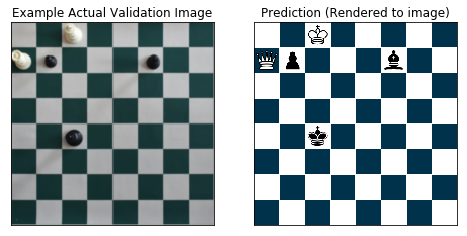

Example image:
Actual: 2r3k1-1b4pp-p7-1pBP1p2-3P4-6P1-PP5K-RN1r4
Guess: 2r3k1-1b4pp-p7-1pBP1p2-3P4-6P1-PP5K-RN1r4
Example Accuracy: 1.0


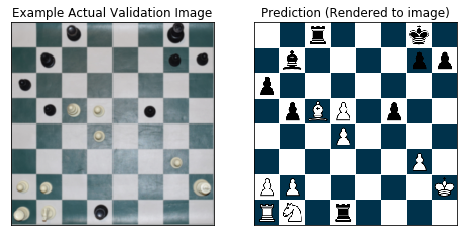

Loading tensorboard data.


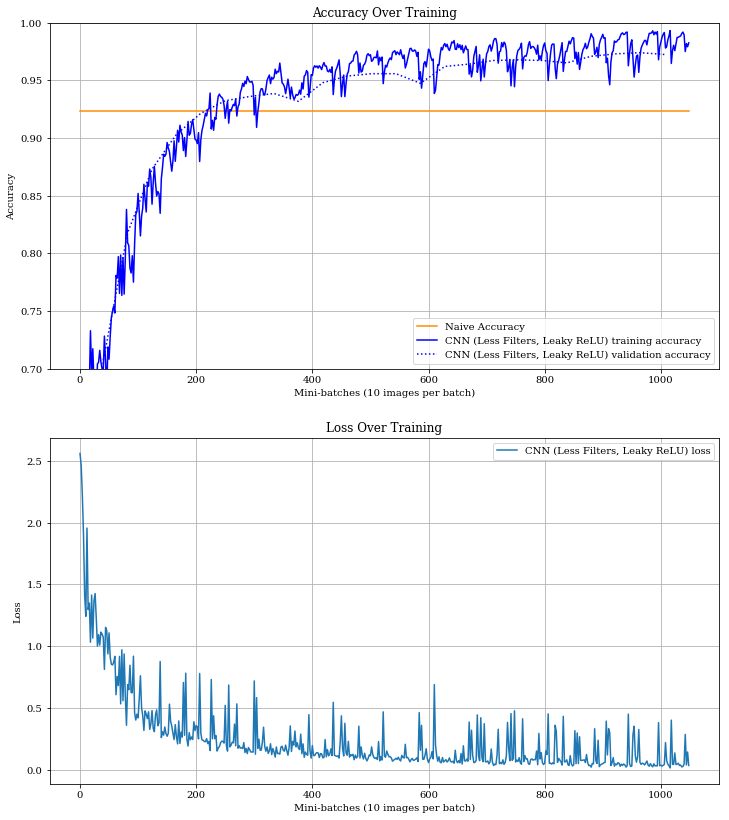

Training: CNN (BatchNorm, Less Filters, Leaky ReLU)
Learning Rate: 0.0005
Training model. Logging to: "./logs/CNN (BatchNorm, Less Filters, Leaky ReLU)_lr0.0005 (6584966.0)/"

Final Train Accuracy: 0.99672620
Final Test Accuracy: 0.99406251
Final Validation Accuracy: 0.98072918
Elapsed Time: 2.72 minutes
Example image:
Actual: rnbqkbnr-pppp1ppp-8-4p3-4P3-8-PPPP1PPP-RNBQKBNR
Guess: rnbqkbnr-pppp1ppp-8-4p3-4P3-8-PPPP1PPP-RNBQKBNR
Example Accuracy: 1.0


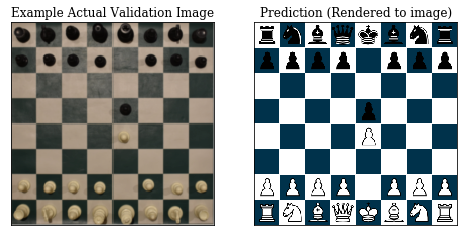

Example image:
Actual: 5rk1-1bp2ppp-p7-1p1P4-3P1B2-6P1-PP5K-RN1r4
Guess: 5rk1-1bp2ppp-p7-1p1P4-3P1B2-6P1-PP5K-RN1r4
Example Accuracy: 1.0


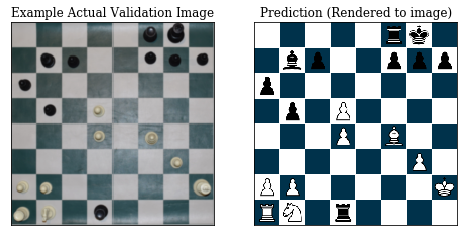

Loading tensorboard data.


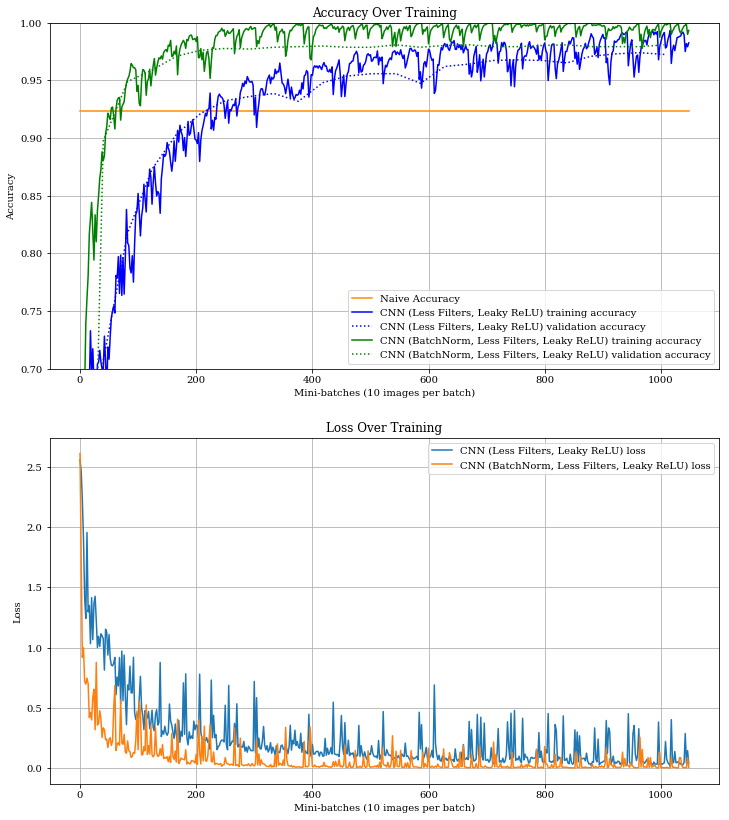

In [26]:
np.warnings.filterwarnings('ignore') # they were getting annoying...

num_epochs = 25
log_freq=2
log_dirs = []
cnns = [CNN_BatchNormLessFiltersLastLayer, CNN_BatchNormLessFilters, CNN_NoDropout, 
        CNN_Dropout, CNN_Dropout_BatchNorm, CNN_BatchNorm]
basic_models = [FullyConnected, LogisticRegression]
all_models = cnns + basic_models
new_models = [CNN_LessFilters, CNN_BatchNormLessFilters]

for learning_rate in [.0005]:
    for model_type in new_models:
        net = model_type(batch_size=BATCH_SIZE)
        print(f'Training: {net.name}\nLearning Rate: {learning_rate}')

        if net.name == 'LogisticRegression (L2 regularization)':
            weight_decay=.05 # add L2 regularizer for logreg
        else: weight_decay=0
        optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

        log_dir = f'./logs/{net.name}_lr{learning_rate}'
        criterion = nn.CrossEntropyLoss().to(device)

        # print a summary of the net statistics
        #         summary(net.to(device), (BATCH_SIZE*32, 3, 25, 25))

        #     images, labels, original_imgs = next(iter(train_loader))
        #     y = net.to(device)(Variable(images.to(device)))
        #     make_dot(y)

        # Run the model
        start_time = time.time()


        model, log_dir, final_train_acc, final_val_acc, final_test_acc = train_model(net,
                                                    log_dir,
                                                    train_loader,
                                                    criterion,
                                                    optimizer,
                                                    num_epochs, 
                                                    log_freq,
                                                    print_guess_freq=100,
                                                    print_guess=False,
                                                    test_model_after_each_epoch=True,
                                                    val_loader=val_loader,
                                                    test_loader=test_loader,
                                                    disable_tqdm=True) # or print_guess=False for tqdm
        log_dirs.append(log_dir)
        elapsed_time = time.time() - start_time
        
        print(f'Final Train Accuracy: {final_train_acc:.8f}')
        print(f'Final Test Accuracy: {final_test_acc:.8f}')
        print(f'Final Validation Accuracy: {final_val_acc:.8f}')
        print(f'Elapsed Time: {elapsed_time/60:.2f} minutes')
        save_model_to_drive(model, f'model_{model.name}_{learning_rate}.pt')
        
#         plot_tensorflow_log(log_dir, title=model.name)
        view_classify(model, test_loader, num_view =2)

        del(model) # just in case :/
        del(criterion)
        del(optimizer)
        del(net)

        plot_tensorflow_logs(log_dirs, include_val=True, inverse_log=False, ylim=[.7,1.0], smoothing_weight=0.6)

----

### Some random code for making visualizations (not part of general notebook functionality)

In [0]:
print(log_dirs)

['./logs/CNN (Leaky ReLU)_lr0.0005 (6207798.0)/', './logs/CNN (Dropout, Leaky ReLU)_lr0.0005 (6208266.0)/', './logs/CNN (BatchNorm, Dropout, Leaky ReLU)_lr0.0005 (6208750.0)/', './logs/CNN (BatchNorm, Leaky ReLU)_lr0.0005 (6209276.0)/', './logs/FullyConnected_lr0.0005 (6209811.0)/', './logs/LogisticRegression (L2 regularization)_lr0.0005 (6211292.0)/']


In [0]:
import pickle
from typing import Dict

def save_object_to_drive(ob: object, 
                         data_save_name = "tb_data.p"):
    ''' Saves object pickle to drive '''
    path = F"/content/gdrive/My Drive/{data_save_name}" 
    pickle.dump( (ob), open( path, "wb" ) )

def load_object_from_drive(data_save_name = "tb_data.p") -> Dict:
    ''' Loads preprocessed data pickle from drive '''
    path = F"/content/gdrive/My Drive/{data_save_name}"
    ob = pickle.load( open( path, "rb" ) )
    return ob

# save_object_to_drive(tb_data)

In [0]:
tb_data = load_object_from_drive()

In [0]:
# tb_data = load_object_from_drive()

In [0]:
tb_data.keys()

dict_keys(['./logs/CNN (BatchNorm, Less Filters Last Layer, Leaky ReLU)_lr0.0005 (6461801.0)/', './logs/CNN (BatchNorm, Less Filters, Leaky ReLU)_lr0.0005 (6461985.0)/', './logs/CNN (Leaky ReLU)_lr0.0005 (6462154.0)/', './logs/CNN (Dropout, Leaky ReLU)_lr0.0005 (6462542.0)/', './logs/CNN (BatchNorm, Dropout, Leaky ReLU)_lr0.0005 (6462940.0)/', './logs/CNN (BatchNorm, Leaky ReLU)_lr0.0005 (6463369.0)/', './logs/FullyConnected_lr0.0005 (6463796.0)/', './logs/LogisticRegression (L2 regularization)_lr0.0005 (6465198.0)/'])

In [0]:
included_mods = ['./logs/CNN (BatchNorm, Less Filters, Leaky ReLU)_lr0.0005 (6461985.0)/',
#  './logs/CNN (Dropout, Leaky ReLU)_lr0.0005 (6462542.0)/', 
#  './logs/FullyConnected_lr0.0005 (6463796.0)/', 
#  './logs/LogisticRegression (L2 regularization)_lr0.0005 (6465198.0)/'
                ]

not_included_mods = ['./logs/CNN (BatchNorm, Dropout, Leaky ReLU)_lr0.0005 (6462940.0)/']
tb_data3 = {k:v for k,v in tb_data.items() if k in included_mods}
# tb_data3 = {k:v for k,v in tb_data.items() if k not in not_included_mods}

['./logs/CNN (Less Filters, Leaky ReLU)_lr0.0005 (6584807.0)/',
 './logs/CNN (BatchNorm, Less Filters, Leaky ReLU)_lr0.0005 (6584966.0)/']

Loading tensorboard data.


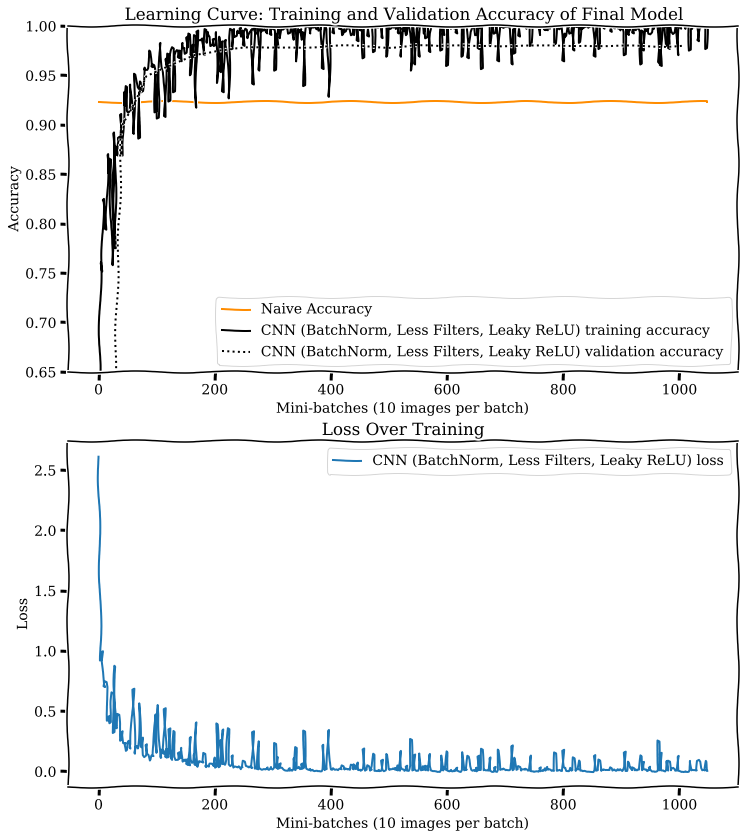

In [41]:
naive_acc = .923
log_dirs2 = ['./logs/CNN (BatchNorm, Less Filters, Leaky ReLU)_lr0.0005 (6584966.0)/']
plot_tensorflow_logs(log_dirs2, include_val=True, 
                     inverse_log=False, 
                     ylim=[.65,1.0], 
                     smoothing_weight=0.0, 
                     include_legend=True,
                     tb_data=None);